In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from spider import SPIDER
op = SPIDER()
import anndata
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np
import umap

In [21]:
sample_name = 'D1'
ds = 'breast_cancer'
out_f = f'../datasets/{ds}/{sample_name}/'
adata = anndata.read_h5ad(f'{out_f}/adata.h5ad')

make sure you have spatialPCA installed first

In [ ]:
no_spatalk = False
if len(adata) > 10000:
    no_spatalk=True
idata = op.prep(adata, out_f, R_path, cluster_key=adata.uns['cluster_key'], is_human=adata.uns['is_human'], coord_type=adata.uns['coord_type'], no_spatalk=no_spatalk)
k = sum(idata.uns['cell_meta'][idata.uns['cell_meta'][adata.uns['cluster_key']] != 'undetermined'][adata.uns['cluster_key']].value_counts() > 20)
i = k+2
j = 20
interface_id = np.where(idata.obs_names == idata.obs[idata.obs['label']=='invasive cancer_invasive cancer'].index[0])[0][0]
count_f = f'{out_f}/idata_full_count.csv'
meta_f = f'{out_f}/idata_full_meta.csv'
idata.to_df().to_csv(count_f)
idata.obs[['row', 'col']].to_csv(meta_f)
with resources.path("spider.R_script", "run_spatialPCA.R") as pw_fn:
    os.system(str(f'/bin/bash -c "{R_path} -f /{pw_fn} {meta_f} {count_f} {k} {j} {out_f} {interface_id} {i}"'))

if you have already run the scripts, you can read the results with

In [22]:
idata = anndata.read_h5ad(f'{out_f}/idata.h5ad')
features = pd.read_csv(f'{out_f}/interface_SpatialPCs.csv', index_col=0).T
idata.obsm['spatialPC'] = features.loc[idata.obs_names].to_numpy()
label_df = pd.read_csv(f'{out_f}/refined_interface_label.csv', index_col=0)
idata.obs['label_spatialPCA'] = label_df.loc[idata.obs_names]['clusterlabel_refine'].to_numpy()
pseudotime = pd.read_csv(f'{out_f}/refined_interface_pseudotime.csv', index_col=0)


analysis

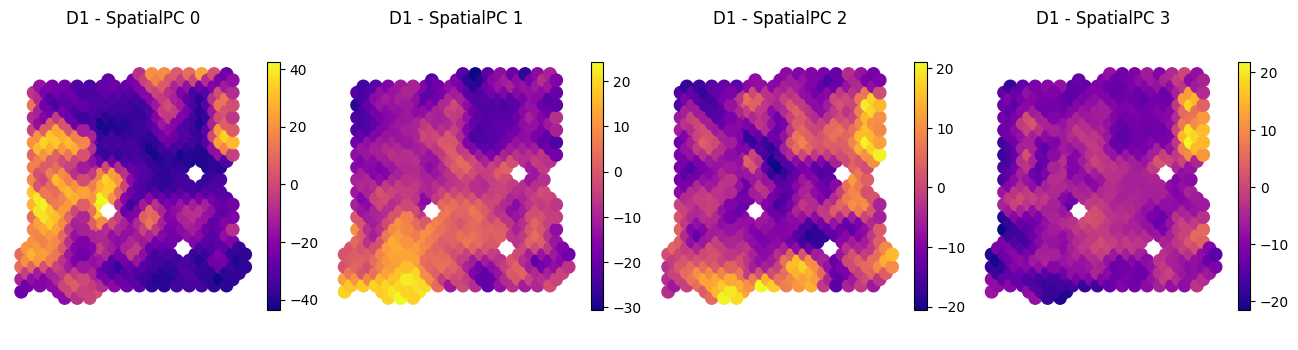

In [32]:
obsm_key = 'spatialPC'
base = 1
plt.figure(figsize=(4*idata.obsm[obsm_key].shape[1], 4))
for i in range(idata.obsm[obsm_key].shape[1]):
    plt.subplot(1, idata.obsm[obsm_key].shape[1], base)
    im=plt.scatter(idata.obs['row'], idata.obs['col'], c=idata.obsm[obsm_key][:,i], s=80, cmap='plasma')
    plt.axis('equal')
    plt.axis('off')
    plt.title(f'{sample_name} - SpatialPC {i}')
    plt.colorbar(im,fraction=0.046, pad=0.04)
    base += 1

(3.1, 22.9, 9.1, 28.9)

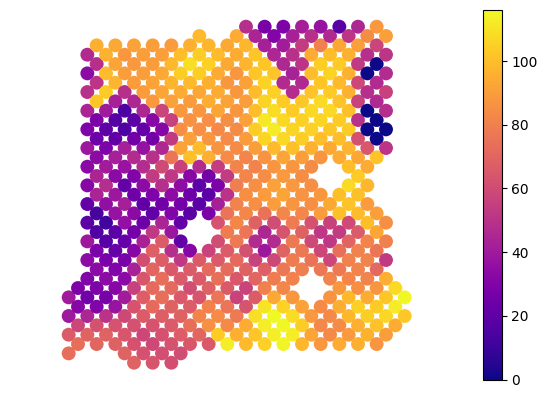

In [34]:
im=plt.scatter(pseudotime['row'], pseudotime['col'], c=pseudotime['pseudotime_traj1'], s=100, cmap='plasma', edgecolors='none',linewidths=0)
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.axis('equal')
plt.axis('off')

(3.1, 22.9, 9.1, 28.9)

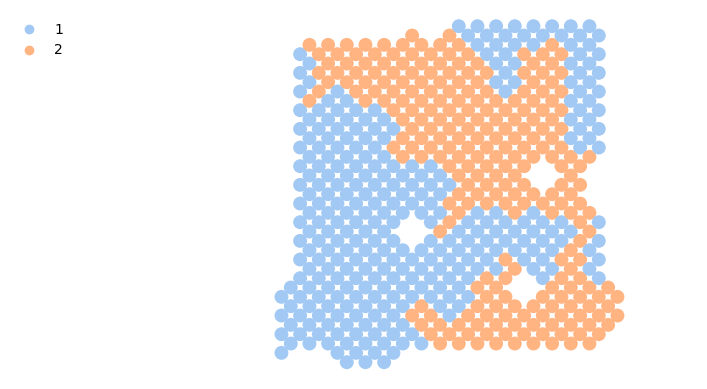

In [23]:
g=sns.scatterplot(data=label_df, x='row', y='col', hue = 'clusterlabel_refine', s=100, palette='pastel', linewidth=0)
g.legend(loc='upper left', bbox_to_anchor=(-0.4, 1), ncol=1,frameon =False)
plt.axis('equal')
plt.axis('off')

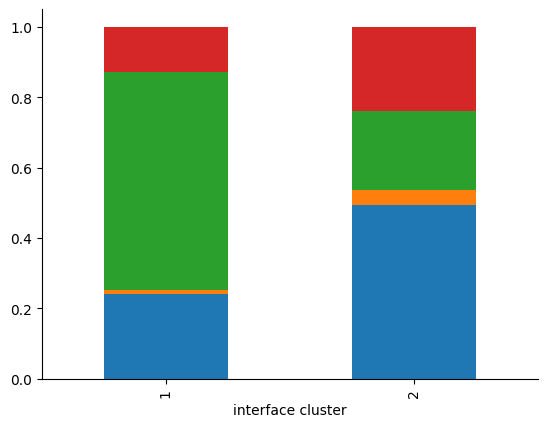

In [36]:
dfs = []
for i in idata.obs['label_spatialPCA'].unique():
    dfs.append(idata.uns['cell_meta'].loc[np.unique(idata.obs[idata.obs['label_spatialPCA']==i][['A', 'B']].to_numpy().flatten()), 'label'].value_counts())
dfs_merged = pd.concat(dfs, axis=1)
dfs_merged.columns=idata.obs['label_spatialPCA'].unique()
dfs_merged = (dfs_merged / dfs_merged.sum()).T.reset_index().rename(columns={'index':'interface cluster'})
g = dfs_merged.plot.bar(x='interface cluster', stacked=True, legend=False)
g.spines[['right', 'top']].set_visible(False)

In [37]:
idata.obs['label_spatialPCA'] = idata.obs['label_spatialPCA'].astype(str).astype('category')
sc.tl.rank_genes_groups(idata, groupby='label_spatialPCA', method='wilcoxon')
marker_df = op.util.get_marker_df(idata, logfoldchanges_threhold=5)

1    17
2    11
Name: cluster, dtype: int64


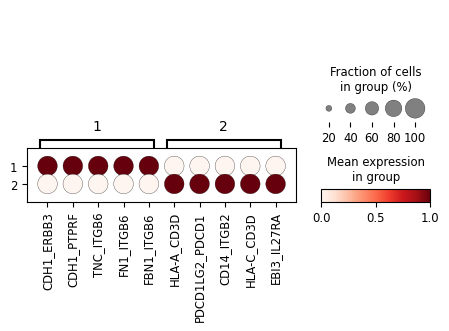

<Figure size 640x480 with 0 Axes>

In [38]:
with plt.rc_context():
    sc.pl.rank_genes_groups_dotplot(idata, n_genes=5, standard_scale='var',)
    # sc.pl.rank_genes_groups_dotplot(idata, n_genes=5,values_to_plot='logfoldchanges', min_logfoldchange=5, vmax=70, vmin=-70, cmap='bwr')
    plt.savefig(f'../figures/{ds}_{sample_name}_spatialpca_marker_dot.png', bbox_inches="tight")

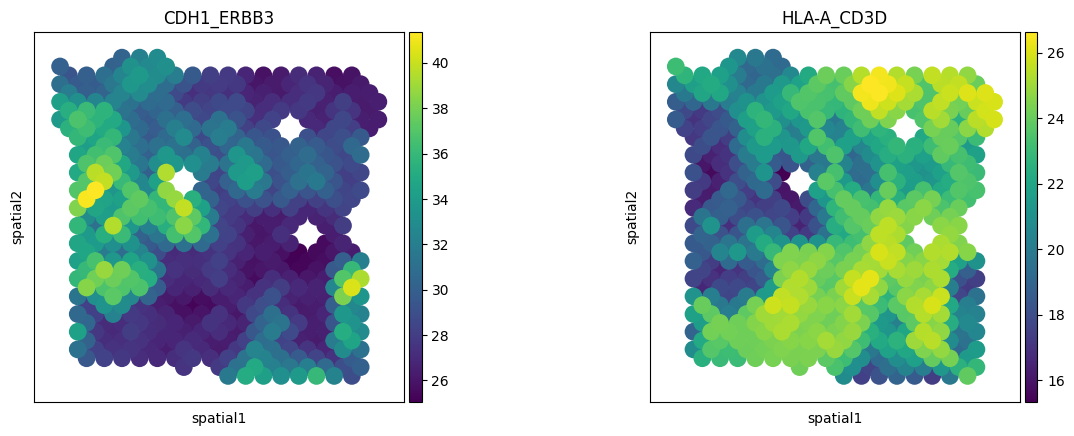

<Figure size 640x480 with 0 Axes>

In [39]:
with plt.rc_context():
    sc.pl.spatial(idata, color=list(idata.uns['rank_genes_groups']['names'][:1].flatten()[0]), spot_size=1)
    plt.savefig(f'../figures/{ds}_{sample_name}_spatialpca_marker_exp.png', bbox_inches="tight")

In [40]:
custom, background = op.er.pathway_prep(idata)
marker_df['g'] = marker_df['names']
marker_df['membership'] = 1
marker_df.to_csv(f'../tables/{ds}_{sample_name}_spatialpca_marker.csv')
merged_df_edge, arr = op.er.enrichment(custom, background, marker_df.set_index('names'), groupby='cluster')
merged_df_edge[merged_df_edge["Adjusted P-value"]<=0.05].to_csv(f'../tables/{ds}_{sample_name}_spatialpca_marker_edge_enrichment.csv')
merged_df_edge.to_csv(f'../tables/{ds}_{sample_name}_spatialpca_marker_edge_enrichment_full.csv')
merged_df, arr = op.er.enrichment_interacrtion_gene_df(marker_df.set_index('names'), groupby='cluster')
merged_df[merged_df["Adjusted P-value"]<=0.05].to_csv(f'../tables/{ds}_{sample_name}_spatialpca_marker_node_enrichment.csv')

Using human LR pair dataset.
